In [1]:
library(pacman)
p_load(dplyr,glarma,boot)

In [2]:
setwd('C:\\Users\\Marcelo\\OneDrive\\Área de Trabalho\\ts\\glarma')
getwd()

[1] "C:/Users/Marcelo/OneDrive/Área de Trabalho/ts/glarma"

# Simulação

Criando a função que simula o processo:

In [3]:
set.seed(123)

In [4]:
simulate_glarma <- function(T = 1000, beta = 0.5, phi = 0, theta = 0.5, x = NULL) {
  if (is.null(x)) x <- rep(1, T)
  
  z <- numeric(T)
  mu <- numeric(T)
  y <- numeric(T)
  e <- numeric(T)
  
  for (t in 1:T) {
    z_t <- 0
    if (t > 1) z_t <- z[t - 1] * phi + e[t - 1] * theta
    
    eta <- beta * x[t] + z_t
    mu[t] <- exp(eta)
    y[t] <- rpois(1, lambda = mu[t])
    e[t] <- (y[t] - mu[t]) / sqrt(mu[t])
    z[t] <- z_t
  }
  
  return(data.frame(time = 1:T, x = x, y = y, mu = mu, z = z,e=e))
}

In [5]:
Amostra_original<-simulate_glarma(T=1000,beta=0.5,phi=0,theta=0.5,x=NULL)

In [6]:
length(Amostra_original$y)

[1] 1000

In [7]:
summary(Amostra_original$y)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.835   3.000  14.000 

In [8]:
X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [9]:
result=glarma(Amostra_original$y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")

In [10]:
Theta<-result$delta[2]
Theta

theta_1 
0.4932373

In [11]:
Beta<-result$delta[1]
Beta

Intercept 
0.4749736

# Bootstrap paramétrico:

In [12]:
B=20

In [13]:
T=length(Amostra_original$y)

gerando as amostras bootstrap:

In [14]:
mu<-Amostra_original$mu

In [15]:
length(mu)

[1] 1000

In [16]:
Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)

In [17]:
for (b in 1:B){
    r = simulate_glarma(T=T,beta=0.5,phi=0,theta=Theta,x=NULL) 
    Y_Bootstrap[,b] <- r$y
    }

Estimando os parâmetros para cada amostra:

In [18]:
recupera_par<- function(Y_col){
    fit<-glarma(Y_col, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    return(fit$delta[2])}

In [19]:
recupera_par(Y_Bootstrap[,2])

theta_1 
0.4712735

In [20]:
Theta_estimates <- apply(Y_Bootstrap, 2, recupera_par)

In [21]:
mean(Theta_estimates)

[1] 0.4946339

In [22]:
quantile(Theta_estimates,probs=c(0.025,0.975))

2.5%     97.5% 
0.4763595 0.5161647

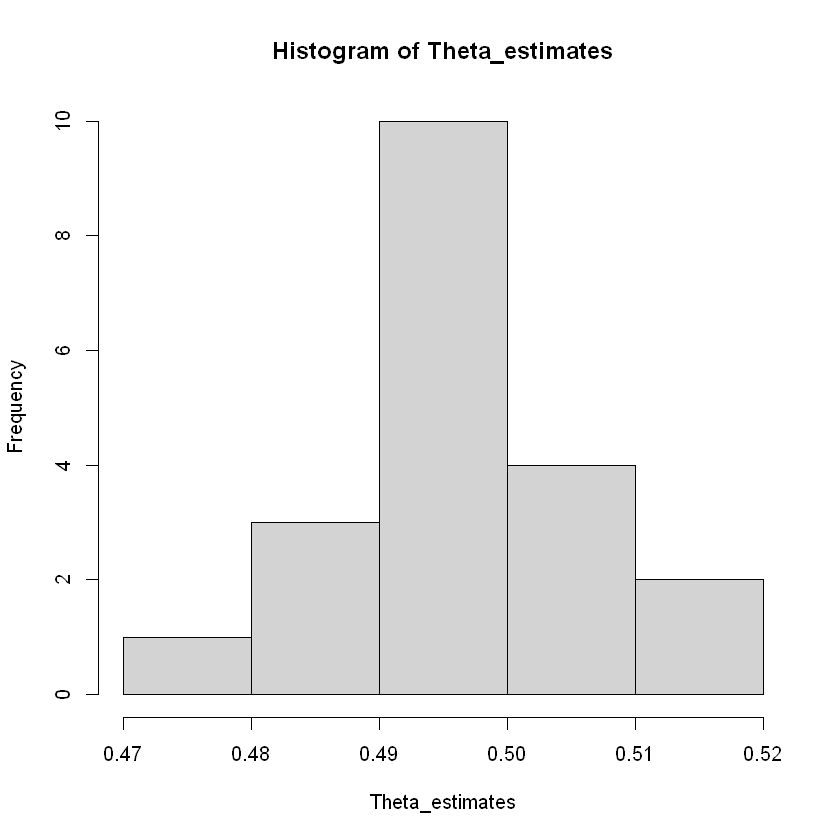

In [23]:
hist(Theta_estimates)

# Bootstrap Não Paramétrico

In [24]:
e<-Amostra_original$e

y<-Amostra_original$y

mu<-Amostra_original$mu

X <- Amostra_original$x
X <- as.matrix(X)
colnames(X) <- "Intercept"

In [25]:
e_boot <- replicate(B, sample(e, size = T, replace = TRUE))

In [26]:
gera_y_boot <- function(e,mu)
{
    
    T <- length(e)
    y <- numeric(T)
    
    for (t in 1:T)
        {
        y[t] = mu[t] + e[t]*sqrt(mu[t])
        y[t] = round(y[t])
        }
    y[y < 1e-12] <- 0
    return(data.frame(y=y))
} 

In [27]:
est_bootstrap <- function(y,X)
{
    fit <- glarma(y, X, phiLags = NULL ,thetaLags = c(1), type = "Poi")
    beta <- fit$delta[1]
    theta <- fit$delta[2]
    
    return(par = c(beta,theta))
}

In [28]:
gera_mu_boot <- function(e,mu,y,x,par)
{
    z <- numeric(T)

    beta <- par[1]
    theta <- par[2]
    
    for (t in 1:T) {
        z_t <- 0
        if (t > 1) z_t <-  e[t - 1] * theta

        eta <- beta * x[t] + z_t
        mu[t] <- exp(eta)
        z[t] <- z_t
      }
    return(mu)
}

In [29]:
bootstrap_n_parametrico <- function(e_boot, mu_init, y, X, B)
{

    T <- length(y)
    Y_Bootstrap <- matrix(NA, nrow = T, ncol = B)
    theta <- numeric(B)

    mu_current <- mu_init  
  
  for (b in 1:B) {
    e <- e_boot[, b]
    
    y_boot <- gera_y_boot(e, mu_current)
    y_boot<-y_boot$y
    Y_Bootstrap[, b] <- y_boot
    
    par <- est_bootstrap(y_boot, X)
    theta[b] <- par[2]
    
    mu_current <- gera_mu_boot(e, mu_current, y_boot, X, par)
  }
   
  return(theta)
}

In [30]:
theta_bootstrap <- bootstrap_n_parametrico(e_boot=e_boot,mu=mu,y=y,X=X,B=B)

In [31]:
mean(theta_bootstrap)

[1] -0.00421505

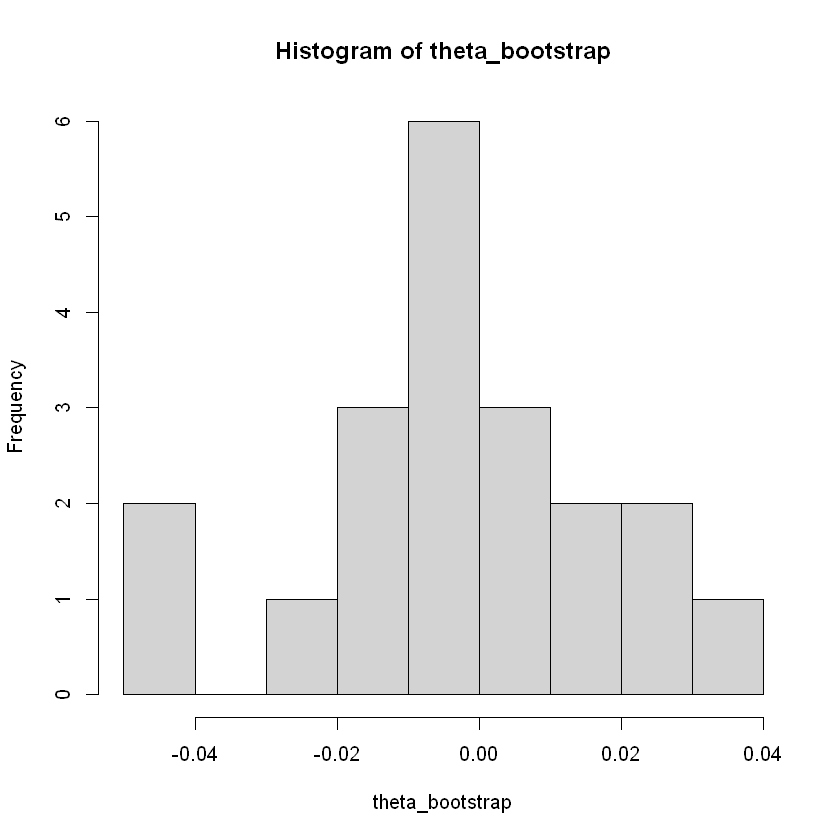

In [32]:
hist(theta_bootstrap)